<a href="https://colab.research.google.com/github/Jaaeeyyyy/DentalCavity-PeriapicalLesionDetection/blob/main/yolov8dentallesion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics roboflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127

In [4]:
from roboflow import Roboflow
from ultralytics import YOLO
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from glob import glob

In [3]:


from roboflow import Roboflow
rf = Roboflow(api_key="r0Y2LHpZtA92Fd4JurfD")
project = rf.workspace("new-workspace-oorwh").project("adr")
version = project.version(7)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to adr-7 in yolov8:: 100%|██████████| 10014/10014 [00:01<00:00, 6328.37it/s]


In [5]:
def preprocess_dental_xray(image_path, target_size=640):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Remove dark borders
    _, thresh = cv2.threshold(img, 5, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    img_cropped = img[y:y+h, x:x+w]

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_cropped)

    # Resize with padding to 640x640
    h, w = img_clahe.shape
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img_clahe, (new_w, new_h))

    top = (target_size - new_h) // 2
    bottom = target_size - new_h - top
    left = (target_size - new_w) // 2
    right = target_size - new_w - left

    padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                cv2.BORDER_CONSTANT, value=0)
    return padded

In [6]:
test_images = glob(os.path.join(dataset.location, "test/images", "*.jpg"))
os.makedirs("preprocessed_test", exist_ok=True)

for img_path in test_images:
    processed = preprocess_dental_xray(img_path)
    filename = os.path.basename(img_path)
    cv2.imwrite(f"preprocessed_test/{filename}", processed)


In [8]:
model = YOLO("yolov8m.pt")  # use yolov8n/s/m/l/x based on resources

results = model.train(
    data=os.path.join(dataset.location, "data.yaml"),
    imgsz=640,
    epochs=30,
    batch=16,
    name="dental_yolo_v8",
    project="dental_detection",
    patience=15,
    pretrained=True
)

Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/adr-7/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=dental_yolo_v82, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.0, pretr

train: Scanning /content/adr-7/train/labels.cache... 4488 images, 312 backgrounds, 0 corrupt: 100%|██████████| 4488/4488 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 441.7±357.7 MB/s, size: 32.9 KB)


val: Scanning /content/adr-7/valid/labels.cache... 307 images, 12 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<?, ?it/s]


Plotting labels to dental_detection/dental_yolo_v82/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to dental_detection/dental_yolo_v82
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.46G      2.485      3.549      1.945         19        640: 100%|██████████| 281/281 [02:31<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]

                   all        307        635      0.141      0.167     0.0746     0.0299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.89G      2.399      2.804      1.853         24        640: 100%|██████████| 281/281 [02:30<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

                   all        307        635      0.254      0.214      0.127     0.0396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      6.86G      2.329      2.668      1.784         26        640: 100%|██████████| 281/281 [02:27<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

                   all        307        635      0.208      0.203      0.144     0.0559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      6.87G      2.272      2.537      1.748         26        640: 100%|██████████| 281/281 [02:26<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]

                   all        307        635       0.34      0.277      0.249     0.0959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      6.97G      2.228       2.37      1.709         16        640: 100%|██████████| 281/281 [02:28<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

                   all        307        635      0.447       0.37      0.353      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      6.98G      2.166      2.314      1.669         13        640: 100%|██████████| 281/281 [02:26<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

                   all        307        635      0.377      0.322      0.299      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.98G      2.172      2.299      1.673         12        640: 100%|██████████| 281/281 [02:26<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]

                   all        307        635      0.432        0.4      0.371      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      6.85G      2.104      2.182      1.618         19        640: 100%|██████████| 281/281 [02:27<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

                   all        307        635      0.443      0.388      0.381      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.96G      2.088      2.092      1.604         23        640: 100%|██████████| 281/281 [02:26<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

                   all        307        635      0.512      0.405      0.421      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.94G      2.074       2.06      1.593         18        640: 100%|██████████| 281/281 [02:26<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]

                   all        307        635      0.495      0.423      0.435      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      6.94G      2.034      1.987      1.577         22        640: 100%|██████████| 281/281 [02:28<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        307        635      0.481      0.406      0.416      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.89G      2.012      1.951      1.557         21        640: 100%|██████████| 281/281 [02:28<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

                   all        307        635      0.513      0.425      0.459      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.96G      2.004      1.945      1.549         11        640: 100%|██████████| 281/281 [02:26<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]

                   all        307        635      0.457      0.455      0.441      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.98G      1.999      1.894      1.541         18        640: 100%|██████████| 281/281 [02:27<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

                   all        307        635      0.537      0.468      0.473      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.92G      1.983      1.842      1.529         21        640: 100%|██████████| 281/281 [02:27<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]

                   all        307        635       0.54      0.495      0.508      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      6.85G      1.961      1.831      1.508         21        640: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

                   all        307        635      0.548      0.509      0.515      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      6.97G      1.955       1.78      1.497         10        640: 100%|██████████| 281/281 [02:26<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

                   all        307        635      0.584      0.477      0.515       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      6.95G      1.902      1.708      1.473         15        640: 100%|██████████| 281/281 [02:27<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]

                   all        307        635      0.531      0.462      0.499      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      6.95G      1.905       1.69      1.469         17        640: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        307        635      0.587      0.481      0.523      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      6.87G      1.898       1.67       1.47         20        640: 100%|██████████| 281/281 [02:26<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]

                   all        307        635      0.545      0.479      0.501      0.226


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.96G      1.869      1.597      1.506         11        640: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

                   all        307        635      0.616      0.519      0.554       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.95G      1.824      1.532      1.485         13        640: 100%|██████████| 281/281 [02:24<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

                   all        307        635      0.585      0.444      0.493      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.94G       1.81      1.474      1.471         15        640: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

                   all        307        635      0.585      0.538      0.561      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.86G      1.781       1.42      1.447         11        640: 100%|██████████| 281/281 [02:26<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

                   all        307        635      0.612      0.494      0.551      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.96G      1.762      1.407      1.452         15        640: 100%|██████████| 281/281 [02:25<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]

                   all        307        635      0.617      0.509      0.558      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.94G      1.731      1.336      1.415         20        640: 100%|██████████| 281/281 [02:27<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        307        635      0.681      0.513      0.588      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.94G      1.706      1.296      1.406         12        640: 100%|██████████| 281/281 [02:24<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]

                   all        307        635      0.662      0.519      0.576      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.85G      1.685      1.247      1.391         10        640: 100%|██████████| 281/281 [02:24<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]

                   all        307        635      0.648      0.503      0.572      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.98G      1.654      1.207      1.366         27        640: 100%|██████████| 281/281 [02:25<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

                   all        307        635      0.647       0.52      0.575      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.93G       1.64      1.168      1.363         11        640: 100%|██████████| 281/281 [02:24<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

                   all        307        635      0.666      0.538      0.596      0.276



30 epochs completed in 1.299 hours.
Optimizer stripped from dental_detection/dental_yolo_v82/weights/last.pt, 52.0MB
Optimizer stripped from dental_detection/dental_yolo_v82/weights/best.pt, 52.0MB

Validating dental_detection/dental_yolo_v82/weights/best.pt...
Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


                   all        307        635      0.668      0.539      0.596      0.276
                cavity        255        471      0.638      0.516       0.55      0.228
                    pa        116        164      0.698      0.563      0.643      0.323
Speed: 0.3ms preprocess, 11.9ms inference, 0.1ms loss, 3.6ms postprocess per image
Results saved to dental_detection/dental_yolo_v82


In [10]:
import pandas as pd

csv_path = "dental_detection/dental_yolo_v8/results.csv"
df = pd.read_csv(csv_path)

print("📄 Available columns:")
print(df.columns.tolist())


📄 Available columns:
['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


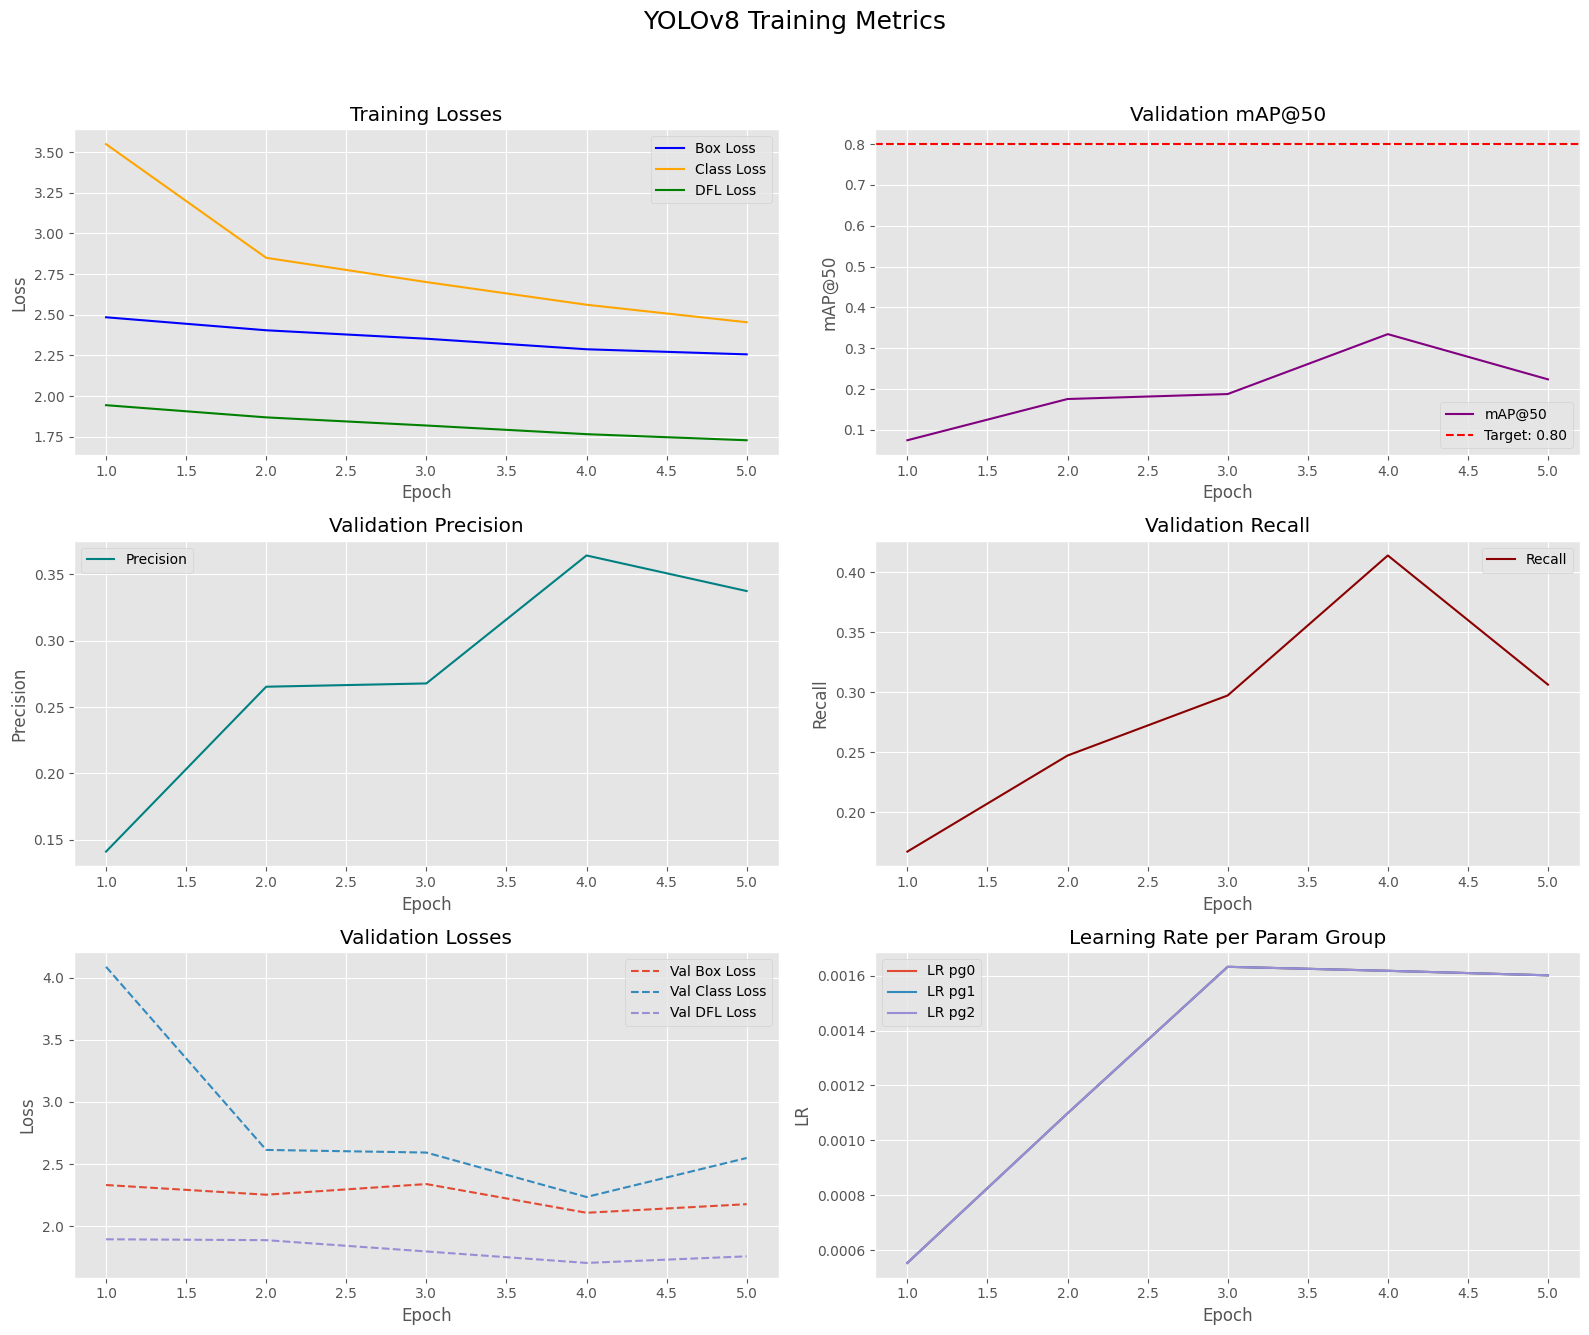

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results CSV
csv_path = "dental_detection/dental_yolo_v8/results.csv"
df = pd.read_csv(csv_path)

# Set plot style
plt.style.use("ggplot")  # or 'default', 'bmh', 'classic'


# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle("YOLOv8 Training Metrics", fontsize=18)

# 1. Training Losses
axs[0, 0].plot(df["epoch"], df["train/box_loss"], label="Box Loss", color="blue")
axs[0, 0].plot(df["epoch"], df["train/cls_loss"], label="Class Loss", color="orange")
axs[0, 0].plot(df["epoch"], df["train/dfl_loss"], label="DFL Loss", color="green")
axs[0, 0].set_title("Training Losses")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()

# 2. Validation mAP@50
axs[0, 1].plot(df["epoch"], df["metrics/mAP50(B)"], color="purple", label="mAP@50")
axs[0, 1].axhline(y=0.8, color='red', linestyle='--', label="Target: 0.80")
axs[0, 1].set_title("Validation mAP@50")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("mAP@50")
axs[0, 1].legend()

# 3. Precision
axs[1, 0].plot(df["epoch"], df["metrics/precision(B)"], color="teal", label="Precision")
axs[1, 0].set_title("Validation Precision")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Precision")
axs[1, 0].legend()

# 4. Recall
axs[1, 1].plot(df["epoch"], df["metrics/recall(B)"], color="darkred", label="Recall")
axs[1, 1].set_title("Validation Recall")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Recall")
axs[1, 1].legend()

# 5. Validation Losses
axs[2, 0].plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle='--')
axs[2, 0].plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle='--')
axs[2, 0].plot(df["epoch"], df["val/dfl_loss"], label="Val DFL Loss", linestyle='--')
axs[2, 0].set_title("Validation Losses")
axs[2, 0].set_xlabel("Epoch")
axs[2, 0].set_ylabel("Loss")
axs[2, 0].legend()

# 6. Learning Rate Schedule
axs[2, 1].plot(df["epoch"], df["lr/pg0"], label="LR pg0")
axs[2, 1].plot(df["epoch"], df["lr/pg1"], label="LR pg1")
axs[2, 1].plot(df["epoch"], df["lr/pg2"], label="LR pg2")
axs[2, 1].set_title("Learning Rate per Param Group")
axs[2, 1].set_xlabel("Epoch")
axs[2, 1].set_ylabel("LR")
axs[2, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
